# Estabilización por Feedback
## Fuente: Mirrahimi, Mazyar, & Van Handel, Ramon (2007). Stabilizing feedback controls for quantum systems. SIAM Journal on Control and Optimization, 46(2), 445-467.
### Ejemplo: Sistema de dos Qubit entrelazados

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.expect import expect_rho_vec
from math import *
from IPython.core.debugger import Pdb
ipdb = Pdb()

In [2]:
#Parametros de simulación
eta = 0.4
gamma = 0.15
T = 25
nsteps = 1000
nsubsteps = 100
ntraj = 1
times = np.linspace(0, T, nsteps)
e0=fock(2,0)                              # Elementos de la base computacional en C^2
e1=fock(2,1)
e00=tensor(e0,e0)                         # Elementos de la base en C^2xC^2
e01=tensor(e0,e1)
e10=tensor(e1,e0)
e11=tensor(e1,e1)
#estado simétrico y antisimétrico
rho_sym=0.5*(e01+e10)*(e01+e10).dag()     #Estados de Bell
rho_asym=0.5*(e01-e10)*(e01-e10).dag()    #maximalmente entrelazados

In [3]:
sigma1_xyz=[tensor(i,qeye(2)) for i in [sigmax(),sigmay(),sigmaz()]] #matrices de pauli del primer bit
sigma2_xyz=[tensor(qeye(2),i) for i in [sigmax(),sigmay(),sigmaz()]] #matrices de pauli del segundo bit
F_xyz=[sigma1_xyz[i]+sigma2_xyz[i] for i in [0,1,2]]                 #operador de momento angular colectivo

Ecuación de filtrado del sistema de dos qubit en $\mathscr{H}=\mathbb{C}^2\otimes\mathbb{C}^2$

$$d\rho_t=-iu_1(t)[\sigma_y^1,\rho_t]dt-iu_2[\sigma_y^2,\rho_t]dt-\frac{1}{2}[F_z,[F_z,\rho_t]]dt+\sqrt{\eta}(F_z\rho_t+\rho_tF_z-2Tr(F_z\rho_t)\rho_t)dW_t$$

Reescribimos la ecuación en términos de 

$$\mathcal{D}[C]\rho=C\rho C-\frac{1}{2}(CC^*\rho+\rho C^*C) $$
y
$$\mathcal{H}[C]\rho=C\rho+\rho C^*-Tr[C\rho+\rho C^*]\rho$$

para un operador $C$, entonces 

$$d\rho_t=-iu_1(t)[\sigma_y^1,\rho_t]dt-iu_2(t)[\sigma_y^2,\rho_t]dt+\mathcal{D}[F_z]\rho_tdt+\sqrt{\eta}\mathcal{H}(F_z)\rho_tdW_t$$

El objetivo de control es estabilizar hacia el estado de Bell $\rho_{asym}$

In [4]:
rho_asym

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

In [5]:
rho0 = tensor(ket2dm(rand_ket(2, density=1)), ket2dm(rand_ket(2, density=1)))  #Condicion inicial aleatoria

Para implementar la ecuación en qutip, (referimos a http://qutip.org/docs/3.1.0/index.html), el solucionador del toolbox proporciona una lista de superoperadores precomputados (denotamos esa lista por $A$ en el código) del operador de colapso que usamos en las funciones D, Du y H.

$$C\rho=A[0] $$
$$\rho C=A[1]$$
$$C^*\rho=A[2] $$
$$\rho C^*=A[3]$$
$$\mathcal{D}[C] =A[7]$$

Para la parte donde se implementan los controles, el Liouvilliano de un observable $H$ dado un estado $\rho$ es $$d\rho_t=-i[H,\rho]$$

En qutip, lo calculamos como $Liouv_{H} \rho=liouvillian(H,[]).data*\rho$  y 
Entonces, en vista de la ecuación de filtrado, tenemos 
$$\rho_{t+1}=iu_1(t)(Liouv_{\sigma_y^1})\rho_t+iu_2(t)(Liouv_{\sigma_y^2})\rho_t +  A[7]\rho_{t} + \sqrt{\eta}(A[0]+A[3]\rho_{t}-Tr(A[0]+A[3])\rho)$$

In [6]:
#     A[0] = spre(c)
#     A[1] = spost(c)
#     A[2] = spre(c.dag())
#     A[3] = spost(c.dag())
#     A[4] = spre(n)
#     A[5] = spost(n)
#     A[6] = (spre(c) * spost(c.dag())
#     A[7] = lindblad_dissipator(c)
#Definimos D[A]
def D(A,rho): #Parte determinista no controlada
    return A[7] * rho   #Generador de linblad
def Du(A,rho):   #Parte determinista controlada
    return (u_a(A,rho)[0]*Liouv_s1*rho+u_a(A,rho)[1]*Liouv_s2*rho)
#Parte determinista  D(A)
def P_Det(t, rho, A, args):
    #return (u_1 * Liouv_s1 * rho_vec + u_2 * Liouv_s2 * rho_vec + A[7] * rho_vec)
    return (Du(A,rho) + D(A,rho))

def H(t, rho, A, args):  #Parte estocastica H(A)
    e1 = expect_rho_vec((A[0]+A[3]), rho, False) 
    return [np.sqrt(eta) * ((A[0]+A[3]) * rho - e1 * rho)]

Ley de control propuesta por Mirrahimi, van Handel (estado antisimetrico):

In [7]:
#Ley de control
B_a=0
#el estado que recibimos es la representación en vector para la matriz de densidad rho, hay que usar vec2mat
Liouv_s1 = liouvillian(sigma1_xyz[1], []).data                         #-i[sigma_y^1,rho]
Liouv_s2 = liouvillian(sigma2_xyz[1], []).data                         #-i[sigma_y^2,rho]

def u_a(A,rho):
    global B_a
    #Calcular la traza de la matriz
    Tr_rho_rhoa=np.sum(vec2mat(rho)*rho_asym.full()).real   #calculamos asi la traza, deberia ser mas rapido
    if Tr_rho_rhoa < gamma / 2:        
        B_a=0
        u_1=1
        u_2=0
    elif Tr_rho_rhoa>=gamma or B_a==1:
        B_a=1
        x=-Liouv_s1*rho    #-(-i[sigma_x^1,rho])
        y=-Liouv_s2*rho    #-(-i[sigma_y^2,rho])
        u_1=1-np.sum(vec2mat(x)*rho_asym.full()).real   ## Tr(rho*rho_asym)
        u_2=1-np.sum(vec2mat(y)*rho_asym.full()).real
    else:
        u_1=1
        u_2=0
    return u_1,u_2


In [8]:
Ham=0*F_xyz[2]   #se ponen los dos Hamiltonianos en la parte determinista ya que los controles actuan sobre el Liouviliano
              #no dentro del Hamiltoniano
e_ops = [sigma1_xyz[0], sigma1_xyz[1], sigma1_xyz[2], sigma2_xyz[0], sigma1_xyz[1], sigma1_xyz[2]]
c_ops = []
sc_ops = [F_xyz[2]]

result=smesolve(Ham, rho0, times, [], sc_ops, e_ops, 
                    ntraj=ntraj, nsubsteps=nsubsteps, d1=P_Det, d2=H,
                    distribution='normal',
                    options=Options(store_states=True, average_states=True))

#tarda 307 segundos usando las estructuras de Qobj
#tarda 88 segundos con numpy

Total run time: 165.61s


In [9]:
def visualize_dynamics(result, rho_f):
    
    fig, axes = plt.subplots(1, 3, figsize=(16,5))

    ## Valores esperados de los grados de libertad colectivos
    axes[0].plot(times, result.expect[0] + result.expect[3], 'r', lw=2, label=r'$\langle F_x\rangle$')
    axes[0].plot(times, result.expect[1] + result.expect[4], 'b', lw=2, label=r'$\langle F_y\rangle$')
    axes[0].plot(times, result.expect[2] + result.expect[5], 'k', lw=2, label=r'$\langle F_z\rangle$')

    axes[0].plot(times, np.ones_like(times) * expect(F_xyz[0], rho_f), 'r--', lw=2)
    axes[0].plot(times, np.ones_like(times) * expect(F_xyz[1], rho_f), 'b--', lw=2)
    axes[0].plot(times, np.ones_like(times) * expect(F_xyz[2], rho_f), 'k--', lw=2)

    axes[0].set_ylim(-2.1, 2.1)
    axes[0].set_xlim(0, times.max())
    axes[0].set_xlabel('time', fontsize=12)
    axes[0].legend(loc=4);    

    ## Valor esperado del qubit 1
    axes[1].plot(times, result.expect[0], 'r', lw=2, label=r'$\langle\sigma_x^{(1)}\rangle$')
    axes[1].plot(times, result.expect[1], 'b', lw=2, label=r'$\langle\sigma_y^{(1)}\rangle$')
    axes[1].plot(times, result.expect[2], 'k', lw=2, label=r'$\langle\sigma_z^{(1)}\rangle$')

    axes[1].plot(times, np.ones_like(times) * expect(sigma1_xyz[0], rho_f), 'r--', lw=2)
    axes[1].plot(times, np.ones_like(times) * expect(sigma1_xyz[1], rho_f), 'b--', lw=2)
    axes[1].plot(times, np.ones_like(times) * expect(sigma1_xyz[2], rho_f), 'k--', lw=2)

    axes[1].set_ylim(-1.1, 1.1)
    axes[1].set_xlim(0, times.max())
    axes[1].set_xlabel('time', fontsize=12)
    axes[1].legend(loc=4);

    ## Valor esperado del qubit 2
    axes[2].plot(times, result.expect[3], 'r', lw=2, label=r'$\langle\sigma_x^{(2)}\rangle$')
    axes[2].plot(times, result.expect[4], 'b', lw=2, label=r'$\langle\sigma_y^{(2)}\rangle$')
    axes[2].plot(times, result.expect[5], 'k', lw=2, label=r'$\langle\sigma_z^{(2)}\rangle$')

    axes[2].plot(times, np.ones_like(times) * expect(sigma2_xyz[0], rho_f), 'r--', lw=2)
    axes[2].plot(times, np.ones_like(times) * expect(sigma2_xyz[1], rho_f), 'b--', lw=2)
    axes[2].plot(times, np.ones_like(times) * expect(sigma2_xyz[2], rho_f), 'k--', lw=2)

    axes[2].set_ylim(-1.1, 1.1)
    axes[2].set_xlim(0, times.max())
    axes[2].set_xlabel('time', fontsize=12)
    axes[2].legend(loc=4)

    return fig, axes

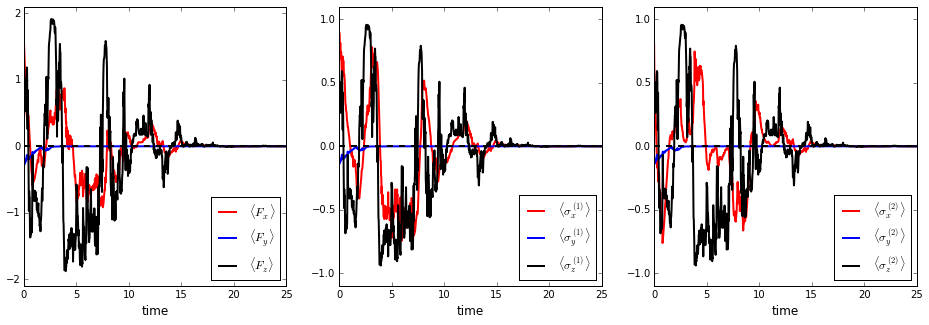

In [10]:
visualize_dynamics(result, rho_asym);

In [11]:
rho = result.states[-1].tidyup(atol=1e-3)   #destino
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.          0.49992079 -0.49984665  0.        ]
 [ 0.         -0.49984665  0.49992075  0.        ]
 [ 0.          0.          0.          0.        ]]

In [97]:
expect(sigma2_xyz[0],rho_asym)

0.0